In [1]:
import numpy as np
import chess

def fen_to_board(fen):
    # Parse the FEN string
    parts = fen.split(" ")
    board_part = parts[0]
    isWhite = parts[1] == 'w'

    # Initialize the binary board
    binary_board = np.zeros((768,), dtype=np.float32)
    pieces = {'p': 0, 'r': 1, 'n': 2, 'b': 3, 'q': 4, 'k': 5,
              'P': 6, 'R': 7, 'N': 8, 'B': 9, 'Q': 10, 'K': 11}
    
    # Parse the board part of the FEN string
    rows = board_part.split('/')
    for i, row in enumerate(rows):
        col = 0
        for char in row:
            if char.isdigit():
                # Empty squares
                col += int(char)
            else:
                # Piece
                if isWhite:
                    binary_board[(i*8 + col)*12 + pieces[char]] = 1
                else:
                    binary_board[(63-(i*8 + col))*12 + (pieces[char]+6)%12] = 1
                col += 1

    return binary_board


In [2]:
from tensorflow.keras import regularizers, layers
import tensorflow as tf
from tensorflow.keras.utils import get_custom_objects

def squared_clipped_relu(x):
    return tf.keras.activations.relu(x, max_value=1)**2

get_custom_objects().update({'squared_clipped_relu': squared_clipped_relu})

main_input = tf.keras.Input(shape=(768,), name='main_input')

x = layers.Dense(768, kernel_regularizer=regularizers.l2(0.01), activation="squared_clipped_relu")(main_input)

x = layers.Dropout(0.5)(x)

output = layers.Dense(1)(x)

model = tf.keras.Model(inputs=main_input, outputs=output)

model.compile(optimizer='adam',
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['mae'])

In [3]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 main_input (InputLayer)     [(None, 768)]             0         
                                                                 
 dense (Dense)               (None, 768)               590592    
                                                                 
 dropout (Dropout)           (None, 768)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 769       
                                                                 
Total params: 591361 (2.26 MB)
Trainable params: 591361 (2.26 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [4]:
import random
# with open(r'fen_ratingsomate2.txt', 'r') as f:
with open(r'akimbo-2085723380.epd', 'r') as f:
    lines = f.readlines()
    
random.shuffle(lines)
fens = [line.split()[0] + " " + line.split()[1] + " " + line.split()[2] for line in lines]
ratings = [(-float(line.split()[-3]) if line.split()[1] == 'b' else float(line.split()[-3]))/1.0 for line in lines] 

binary_boards = []

for fen in fens:
    binary_board = fen_to_board(fen)
    binary_boards.append(binary_board)

binary_boards = np.array(binary_boards)
ratings = np.array(ratings)


In [5]:
train_size = int(len(binary_boards) * 0.8)
val_size = int(len(binary_boards) * 0.10)

# Separate binary boards and piece amounts
x_binary_train, y_train = binary_boards[:train_size], ratings[:train_size]
x_binary_val, y_val = binary_boards[train_size:train_size + val_size], ratings[train_size:train_size + val_size]
x_binary_test, y_test = binary_boards[train_size + val_size:], ratings[train_size + val_size:]


In [6]:
from tensorflow.keras.callbacks import EarlyStopping

# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    x_binary_train,
    y_train,
    validation_data=(x_binary_val, y_val),
    batch_size=64,
    epochs=100,  
    callbacks=[early_stopping]
)


Epoch 1/100


35530/35530 [==============================] - 325s 9ms/step - loss: 90517.4922 - mae: 222.4072 - val_loss: 63421.6094 - val_mae: 188.2709
Epoch 2/100
35530/35530 [==============================] - 334s 9ms/step - loss: 60725.5078 - mae: 185.2457 - val_loss: 52099.2500 - val_mae: 169.1201
Epoch 3/100
35530/35530 [==============================] - 277s 8ms/step - loss: 54669.9102 - mae: 174.4559 - val_loss: 47753.9141 - val_mae: 160.0250
Epoch 4/100
35530/35530 [==============================] - 277s 8ms/step - loss: 51902.7148 - mae: 169.0872 - val_loss: 45288.4492 - val_mae: 154.6262
Epoch 5/100
35530/35530 [==============================] - 265s 7ms/step - loss: 50267.9023 - mae: 165.7785 - val_loss: 43736.2305 - val_mae: 151.0091
Epoch 6/100
35530/35530 [==============================] - 353s 10ms/step - loss: 49102.3984 - mae: 163.3394 - val_loss: 43307.8047 - val_mae: 150.1667
Epoch 7/100
35530/35530 [==============================] - 348s 10ms/step - loss: 48199.445

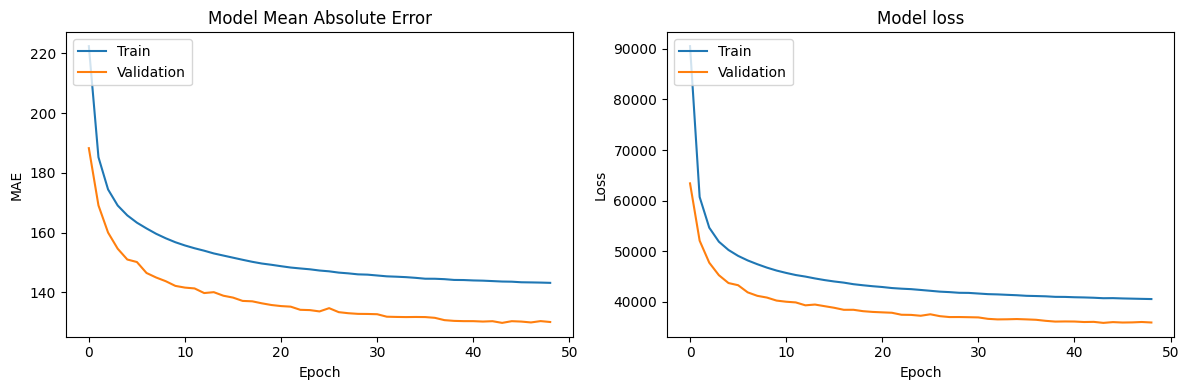

In [7]:
import matplotlib.pyplot as plt

# Plot training & validation MAE values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['mae'])  
plt.plot(history.history['val_mae']) 
plt.title('Model Mean Absolute Error')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [8]:
model.save('TrainedModel.keras')

938/938 [==============================] - 3s 3ms/step


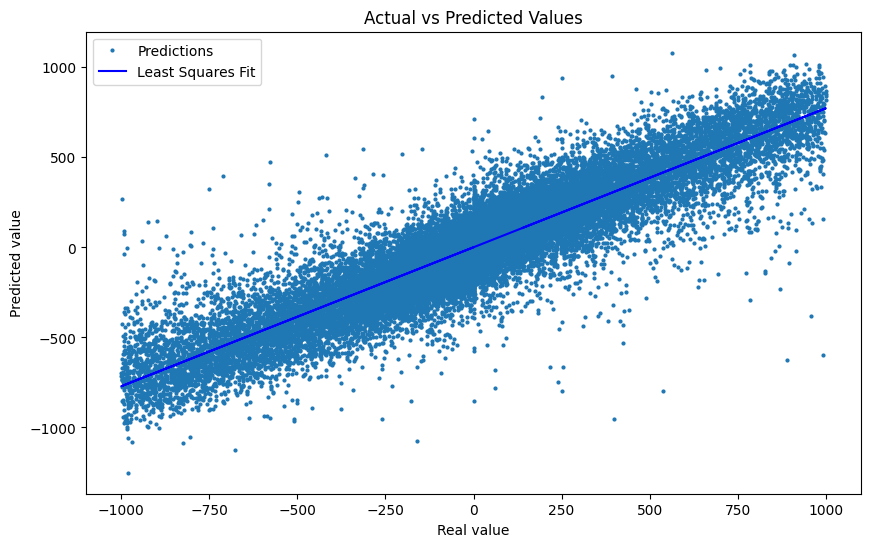

Predicted rating: [53.95741], True rating: 139.0
Predicted rating: [619.73254], True rating: 529.0
Predicted rating: [620.8647], True rating: 827.0
Predicted rating: [45.792824], True rating: 30.0
Predicted rating: [398.52957], True rating: 157.0
Predicted rating: [351.97903], True rating: 411.0
Predicted rating: [27.90966], True rating: 6.0
Predicted rating: [113.99997], True rating: -7.0
Predicted rating: [-424.01547], True rating: -982.0
Predicted rating: [-97.73503], True rating: -62.0
Predicted rating: [805.3927], True rating: 887.0
Predicted rating: [-25.131283], True rating: -156.0
Predicted rating: [74.31853], True rating: -0.0
Predicted rating: [256.1272], True rating: 258.0
Predicted rating: [-639.4244], True rating: -961.0
Predicted rating: [796.60986], True rating: 950.0
Predicted rating: [77.52699], True rating: 27.0
Predicted rating: [476.5556], True rating: -579.0
Predicted rating: [72.90073], True rating: 146.0
Predicted rating: [-308.18127], True rating: -391.0
Predict

In [7]:
def squared_clipped_relu(x):
    return tf.keras.activations.relu(x, max_value=1)**2

from tensorflow.keras.models import load_model

# tf.compat.v1.disable_eager_execution()
get_custom_objects().update({'squared_clipped_relu': squared_clipped_relu})
model = load_model(r"TrainedModel.keras")

import matplotlib.pyplot as plt
import numpy as np

x_test = x_binary_test[:30000]
# Predict the ratings for the test data
y_pred = model.predict(x_test)

plt.figure(figsize=(10, 6))

# Scatter plot of actual vs predicted values
plt.plot(y_test[:30000], y_pred, marker='o', linestyle='None', markersize=2.0, label='Predictions')


# Least squares fit line
coeff = np.polyfit(y_test[:30000].flatten(), y_pred.flatten(), 1)
fit_line = np.polyval(coeff, y_test[:30000].flatten())
plt.plot(y_test[:30000], fit_line, color='blue', label='Least Squares Fit')

plt.title('Actual vs Predicted Values')
plt.xlabel('Real value')
plt.ylabel('Predicted value')
plt.legend()

plt.show()

# Print the predicted and true ratings for the test data
for i in range(min(len(x_test), 300)):
    print(f"Predicted rating: {y_pred[i]}, True rating: {y_test[i]}")